## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (train_test_split, GridSearchCV, KFold)

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import (ReduceLROnPlateau, EarlyStopping)
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, Flatten)
from keras import losses
from keras import metrics
from keras import optimizers
from keras import initializers
from keras import regularizers

np.random.seed(42)
import pickle
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload

Using TensorFlow backend.


In [2]:
train_og = pd.read_csv('../input/train.csv')
train_og = train_og.copy()
test_X_og = pd.read_csv('../input/test.csv')
test_X_og = test_X_og.copy()
train_X_og = train_og[train_og.columns[1:]]
train_Y_og = train_og['label']
X_og = pd.concat([train_X_og, test_X_og])

## Look at Y Value Distribution

In [3]:
# print(train_Y_og.value_counts().sort_index())

## Y Value One Hot Encoding Transformation

In [4]:
train_Y_pre_transform = train_Y_og.copy()
train_Y_pre_split = (OneHotEncoder(sparse=False).
                     fit_transform(train_Y_pre_transform.values.reshape(-1, 1)))

## Check Missing Value

In [5]:
# print('train Y missing value:', train_Y_og.isnull().any())
# print('X missing value:', X_og.isnull().any().value_counts().index[0])
# print('there is no missing value in both X and Y dataset')

## X Value Normalization

In [6]:
X_pre_transform = X_og.copy()
X = np.divide(X_pre_transform, 255)

## X Value Reshape

In [7]:
# according to the description file for the dataset
# reshape image in 3 dimensions (height=28px, width=28px , channel=1)
X = X.values.reshape(-1, 28, 28, 1)


## Take a Look

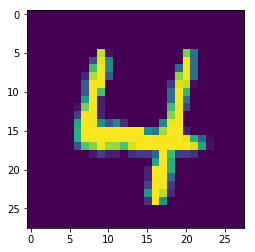

In [8]:
number = 42
plt.imshow(X[number][:,:,0])

## Create Train, Dev, Test set

In [9]:
train_X_pre_split = X[:train_X_og.shape[0]]
test_X = X[train_X_og.shape[0]:]
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X_pre_split, train_Y_pre_split, random_state=42)

In [10]:
print('train X shape:', train_X.shape)
print('train Y shape:', train_Y.shape)
print('dev X shape:', dev_X.shape)
print('dev Y shape:', dev_Y.shape)
print('test X shape:', test_X.shape)

train X shape: (31500, 28, 28, 1)
train Y shape: (31500, 10)
dev X shape: (10500, 28, 28, 1)
dev Y shape: (10500, 10)
test X shape: (28000, 28, 28, 1)


## Model

In [11]:
def model_cnn(train_X, train_Y, dev_X, dev_Y, 
              optimizer='Adam', kernel_initializer='he_normal', bias_initializer='he_normal', batch_size=32, epochs=50, verbose=1):

    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import ReduceLROnPlateau
    from keras.models import Sequential
    from keras.layers import (Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten)
    from keras import losses
    from keras import metrics
    from keras import optimizers
    from keras import initializers
    from keras import regularizers
    
    model = Sequential()
    
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same', input_shape=(28, 28, 1), 
                     kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    
    image_augmentation = ImageDataGenerator(
                        featurewise_center=False, samplewise_center=False, 
                        featurewise_std_normalization=False, samplewise_std_normalization=False, 
                        zca_whitening=False, zca_epsilon=1e-06, 
                        rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                        brightness_range=None, shear_range=0.0, zoom_range=0.1, channel_shift_range=0.0, 
                        fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False)
    
    image_augmentation.fit(train_X)
    
    lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    
    
    history = model.fit_generator(image_augmentation.flow(train_X,train_Y, batch_size=batch_size),
                                  epochs=epochs, validation_data=(dev_X, dev_Y), 
                                  steps_per_epoch=np.ceil(train_X.shape[0]/batch_size), 
                                  verbose=verbose,
                                  callbacks=[lr_reduction])
    return model, history

In [12]:
def plot_result(history):
    import matplotlib.pyplot as plt

    print('train set loss: {:.4f}'.format(history.history['loss'][-1]))
    print('dev set loss: {:.4f}'.format(history.history['val_loss'][-1]))
    print('train set accuracy: {:.4f}'.format(history.history['acc'][-1]))
    print('dev set accuracy: {:.4f}'.format(history.history['val_acc'][-1]))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Dev Loss'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Dev Accuracy'], loc='upper right')
    plt.show()

In [13]:
model, history = model_cnn(train_X, train_Y, dev_X, dev_Y, 
                           optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), 
                           batch_size=1024, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
12/31 [==========>...................] - ETA: 10s - loss: 4.4062 - acc: 0.1523

KeyboardInterrupt: 

In [ ]:
plot_result(history)

In [ ]:
pickle.dump(model, open('model_nn.sav', 'wb'))
model_load = pickle.load(open('model_nn.sav', 'rb'))
y_prob = model_load.predict(test_X)
y_class = np.argmax(y_prob, axis=1)

y_label = pd.Series(y_class, name="Label")
y_idx = pd.Series(range(1,28001), name = "ImageId")
submit = pd.concat([y_idx, y_label], axis=1)
submit.to_csv("y_nn.csv",index=False)

----

## GridSearchCV

In [ ]:
def model_cnn(train_X, train_Y, dev_X, dev_Y, 
              optimizer='Adam', kernel_initializer='he_normal', bias_initializer='he_normal', batch_size=32, epochs=50, verbose=1):

    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import ReduceLROnPlateau
    from keras.models import Sequential
    from keras.layers import (Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten)
    from keras import losses
    from keras import metrics
    from keras import optimizers
    from keras import initializers
    from keras import regularizers
    
    model = Sequential()
    
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same', input_shape=(28, 28, 1), 
                     kernel_initializer=kernel_initializer, 
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(128, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(Conv2D(256, activation='relu', kernel_size=(3, 3), padding='Same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    
    return model

In [ ]:
def gridsearchcv(model_grid, param_grid, verbose=0):
    from keras.wrappers.scikit_learn import KerasClassifier
    from sklearn.model_selection import (GridSearchCV, KFold)
    
    model_grid = KerasClassifier(build_fn=model_grid, verbose=verbose)
    grid = GridSearchCV(model_grid, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42))
    grid_result = grid.fit(train_X, train_Y)
    print('grid search best parameters:', grid_result.best_params_)
    print('grid search best scores: {:.4f}'.format(grid_result.best_score_))
    
    return grid_result

In [ ]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
kernel_initializer = ['lecun_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'lecun_normal', 'he_uniform']
bias_initializer = ['lecun_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'lecun_normal', 'he_uniform']
batch_size = [16, 32, 64, 128]
epochs = [50]

In [ ]:
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)

In [ ]:
# grid_result = gridsearchcv(model_grid, param_grid, verbose=0)